In [1]:
!pip install kaggle
!pip install imbalanced-learn
!pip install nltk tensorflow matplotlib scikit-learn

import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import kagglehub
import os
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
path = kagglehub.dataset_download("advaithsrao/enron-fraud-email-dataset")
csv_file_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(csv_file_path)

# Display dataset information
print("Dataset Preview:\n", df.head())
df.info()

# Drop missing values
df = df.dropna(subset=['Body', 'Label'])

# Define a preprocessing function
def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply preprocessing
df['Body'] = df['Body'].apply(preprocess_text)

# Remove duplicates
df = df.drop_duplicates(subset=['Body'], keep='first')

# Check class distribution
print("Class Distribution Before Balancing:\n", df['Label'].value_counts())


100%|██████████| 214M/214M [00:02<00:00, 96.3MB/s]

Extracting files...



<ipython-input-2-69b1c383f2b7>:14: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


Dataset Preview:
   Folder-User Folder-Name                                     Message-ID  \
0     maildir    arnold-j  <17334447.1075857585446.JavaMail.evans@thyme>   
1     maildir    arnold-j  <19171686.1075857585034.JavaMail.evans@thyme>   
2     maildir    arnold-j  <29887033.1075857630725.JavaMail.evans@thyme>   
3     maildir    arnold-j   <2526360.1075857584903.JavaMail.evans@thyme>   
4     maildir    arnold-j  <30102065.1075857630952.JavaMail.evans@thyme>   

                                    Date                     From  \
0  Thu, 16 Nov 2000 09:30:00 -0800 (PST)          msagel@home.com   
1   Fri, 8 Dec 2000 05:05:00 -0800 (PST)  slafontaine@globalp.com   
2  Tue, 15 May 2001 09:43:00 -0700 (PDT)  iceoperations@intcx.com   
3  Mon, 11 Dec 2000 23:52:00 -0800 (PST)       klarnold@flash.net   
4  Mon, 14 May 2001 23:59:00 -0700 (PDT)    soblander@carrfut.com   

                                                  To  \
0                                  jarnold@enron.com  

<ipython-input-2-69b1c383f2b7>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


Class Distribution Before Balancing:
 Label
0    226010
1      1677
Name: count, dtype: int64


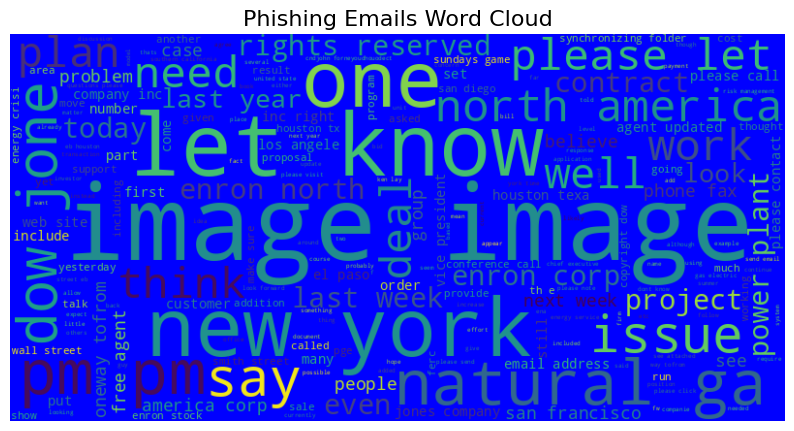

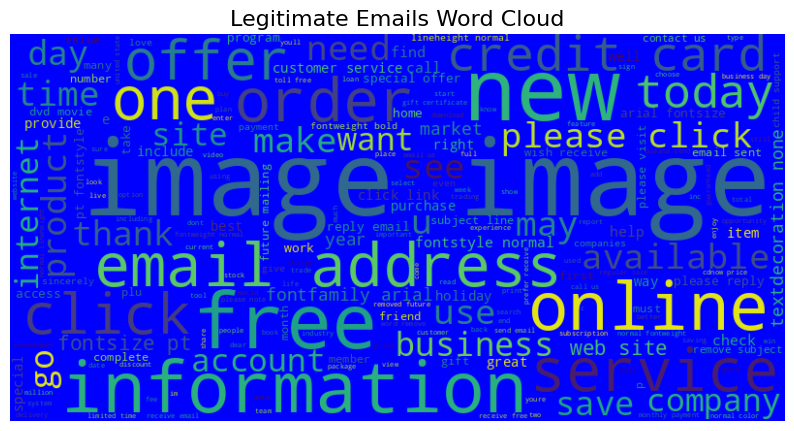

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Generate Word Clouds
def plot_wordcloud(text, title):
    wordcloud = WordCloud(background_color='blue', max_words=200, width=800, height=400).generate(' '.join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Separate text for each label
phishing_text = df[df['Label'] == 0]['Body']
legit_text = df[df['Label'] == 1]['Body']

# Plot word clouds
plot_wordcloud(phishing_text, "Phishing Emails Word Cloud")
plot_wordcloud(legit_text, "Legitimate Emails Word Cloud")


In [6]:
from sklearn.utils import resample

# Separate classes
legit = df[df['Label'] == 1]
phishing = df[df['Label'] == 0]

# Oversample the minority class
phishing_upsampled = resample(
    phishing, replace=True, n_samples=len(legit), random_state=42
)

# Combine and shuffle the data
df_balanced = pd.concat([legit, phishing_upsampled]).sample(frac=1, random_state=42)

# Final class distribution
print("Class Distribution After Balancing:\n", df_balanced['Label'].value_counts())


Class Distribution After Balancing:
 Label
1    1677
0    1677
Name: count, dtype: int64


In [7]:
max_words = 20000  # Vocabulary size
max_length = 200   # Max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['Body'])
sequences = tokenizer.texts_to_sequences(df_balanced['Body'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Split data
X = padded_sequences
y = df_balanced['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (2683, 200)
Testing Data Shape: (671, 200)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Define the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    LSTM(64, kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(32, activation="relu", kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

# Explicitly build the model (if needed)
model.build(input_shape=(None, max_length))  # None = dynamic batch size

# Compile the model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Display the model summary
model.summary()






/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,611,905 (9.96 MB)

 Trainable params: 2,611,713 (9.96 MB)

 Non-trainable params: 192 (768.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Stop if no improvement for 3 epochs
    mode='max',
    verbose=1
)

# Train the model with adjusted hyperparameters
batch_size = 32
epochs = 20  # Train longer to allow more convergence

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.5179 - loss: 4.0247 - val_accuracy: 0.4993 - val_loss: 2.0830
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.5187 - loss: 1.9661 - val_accuracy: 0.4993 - val_loss: 1.4785
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.5136 - loss: 1.4521 - val_accuracy: 0.4993 - val_loss: 1.2237
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.5506 - loss: 1.1606 - val_accuracy: 0.5678 - val_loss: 1.0483
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.5725 - loss: 0.9685 - val_accuracy: 0.4993 - val_loss: 1.4057
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.7752 - loss: 0.7305 - val_accuracy: 0.7973 - val_loss: 0.8697
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.8166 - loss: 0.6540 - val_accuracy: 0.8674 - val_loss: 0.5685
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.8816 - loss: 0.5174 - val_accu

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Model Accuracy: 0.8450

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.75      0.83       336
           1       0.79      0.94      0.86       335

    accuracy                           0.85       671
   macro avg       0.86      0.85      0.84       671
weighted avg       0.86      0.85      0.84       671



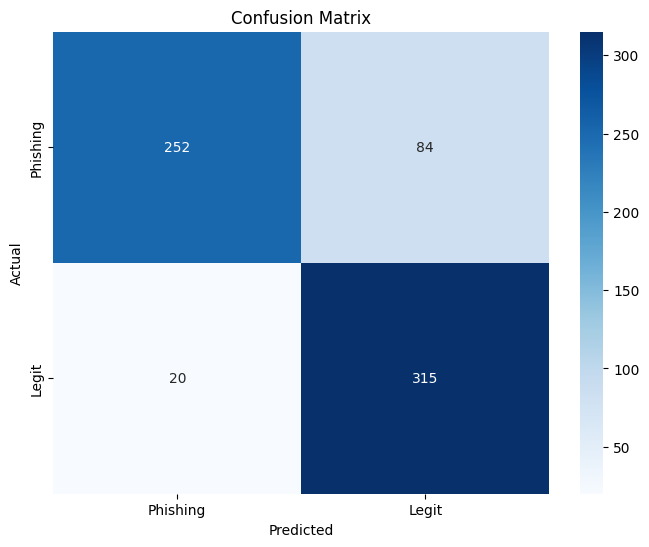

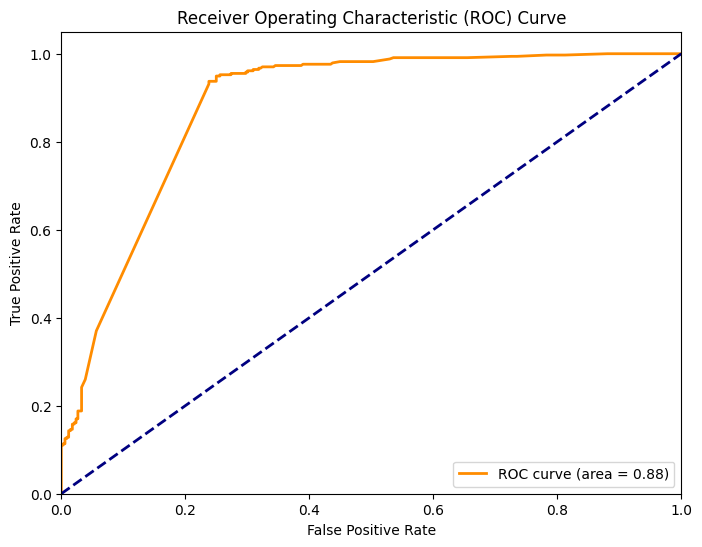

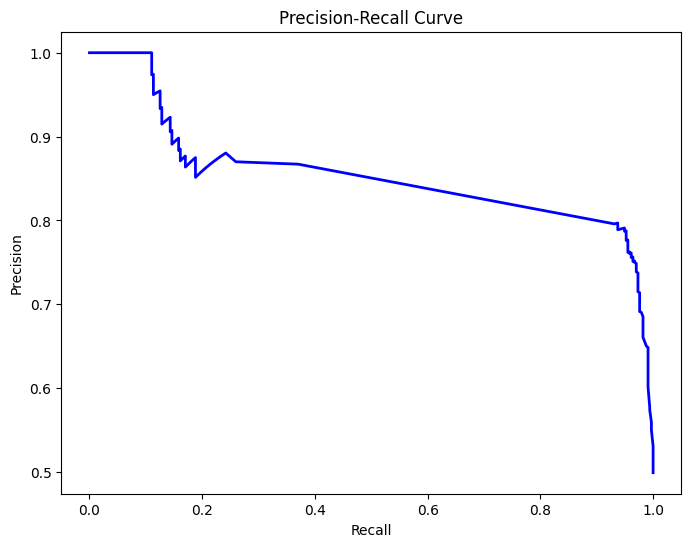

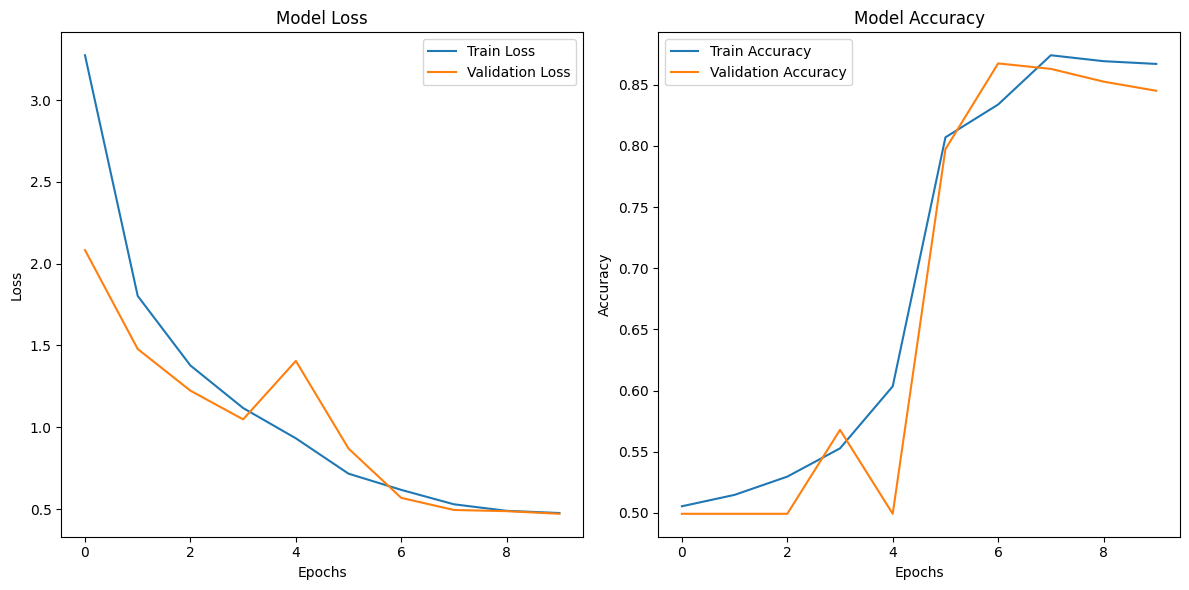

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_prob = model.predict(X_test)  # Probabilities for ROC and PR curves

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Phishing', 'Legit'], yticklabels=['Phishing', 'Legit'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
